(a) Build a classifier that classifies sequences into one of the 14 activities provided and evaluate its performance using average accuracy over 3 fold cross validation. To do the cross validation, divide the data for each class into 3 folds separately. Then, for a given run you will select 2 folds from each class for training and use the remaining fold from each class for test. To make features, you should vector quantize, then use a histogram of cluster center. This method is described in great detail in the book in section 9.3 which begins on page 166. You will find it helpful to use hierarchical k-means to vector quantize. You may perform the vector quantization for the entire dataset before doing cross validation.

You may use whatever multi-class classifier you wish, though we'd suggest you use a decision forest because it's easy to use and effective.

You should report (i) the average error rate over 3 fold cross validation and (ii) the class confusion matrix of your classifier for the fold with the lowest error, i.e. just one matrix for the 3 folds.

(b) Now see if you can improve your classifier by (i) modifying the number of cluster centers in your hierarchical k-means and (ii) modifying the size of the fixed length samples that you see.

In [121]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import AgglomerativeClustering

In [122]:
#read the data and label
activities = ["brush_teeth","climb_stairs","comb_hair","descend_stairs","drink_glass","eat_meat","eat_soup","getup_bed","liedown_bed","pour_water","sitdown_chair","standup_chair","use_telephone","walk"]
activities_index_map = {k:activities.index(k) for k in activities}
data = []   #[[x y z],]
examples = {}  #label:[example0,example2,...]
dirs = os.listdir("./HMP_Dataset")
for dir in dirs:
    if dir[0] != '.' and os.path.isdir("./HMP_Dataset/" + dir):
        files = os.listdir("./HMP_Dataset/" + dir)
        l = activities_index_map[dir.lower()]
        examples[l] = []
        for file in files:
            df = pd.read_csv("./HMP_Dataset/" + dir + "/" + file, sep=" ", header = None)
            if len(data) == 0:
                data = df.values
            else:
                data = np.concatenate((data, df.values), axis=0)
            examples[l] += [df.values]

In [123]:
#take samples sequentially
sample_length = 32
data_sample = data[:len(data)//sample_length * sample_length].reshape((len(data)//sample_length, sample_length*3))  #[[x0,y0,z0,x1,y1,z1,...],]
#implement 50% overlap to get more data samples 
#tmp = data[:len(data)//16 * 16].reshape((len(data)//16, 16*3))
#data_sample = np.array(list(map(lambda x:np.concatenate((x[0],x[1]), axis = 0), list(zip(tmp[:-1],tmp[1:])))))


In [124]:
#form clusters
num_clusters = 480
kmeans = KMeans(num_clusters)
kmeans.fit(data_sample)


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=480, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

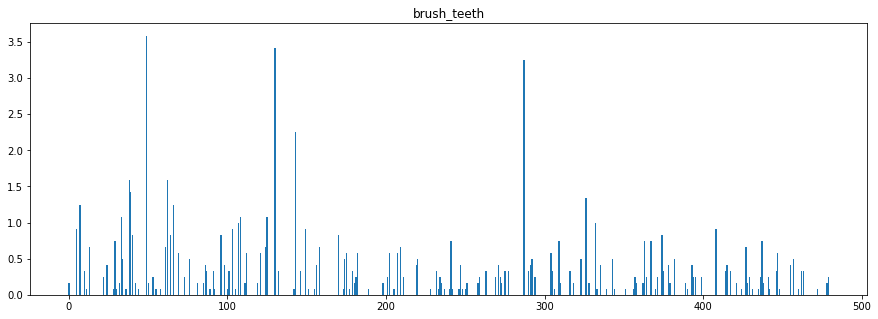

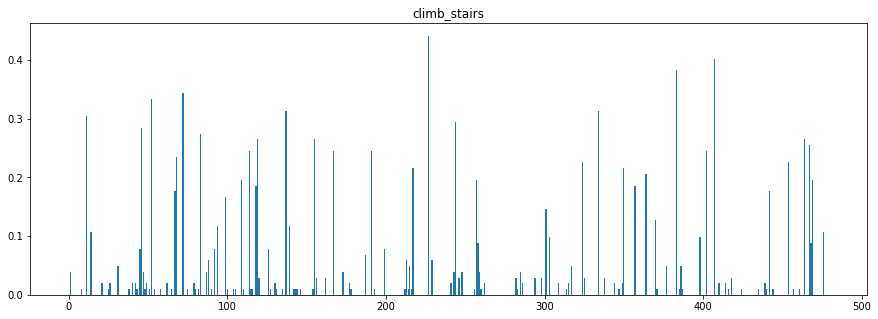

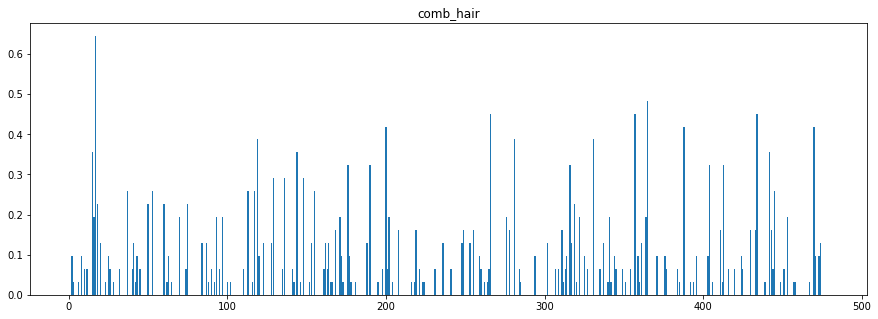

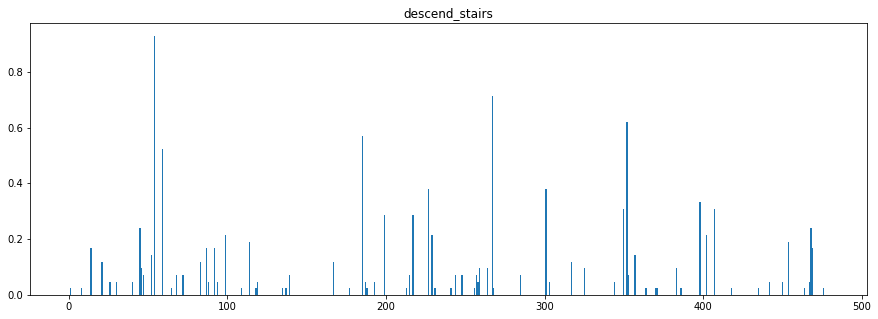

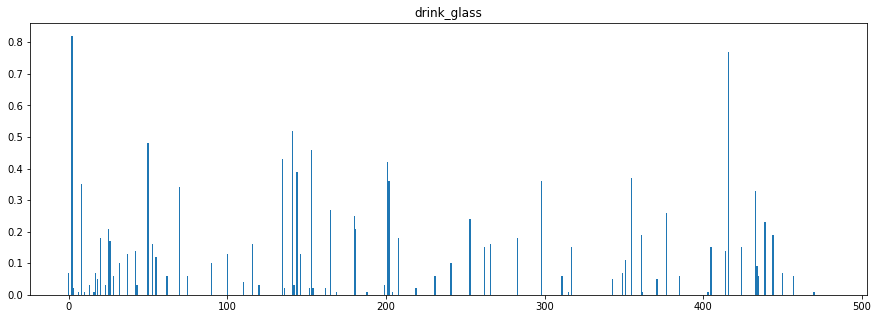

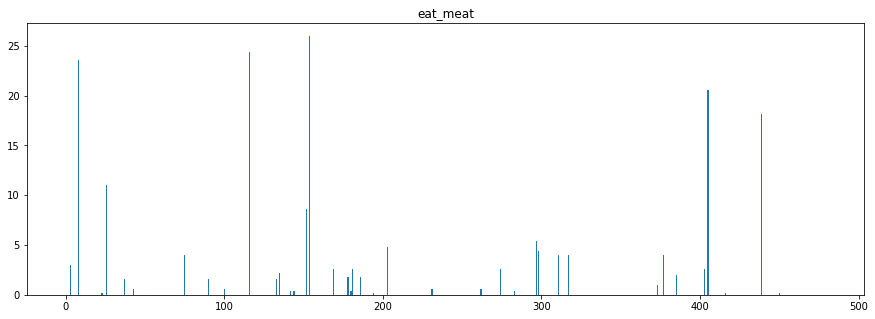

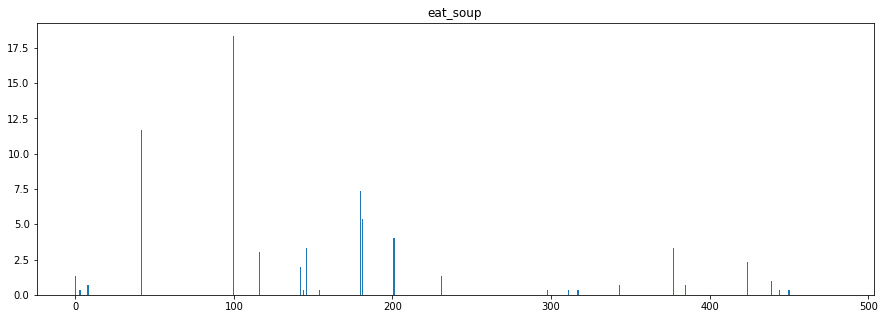

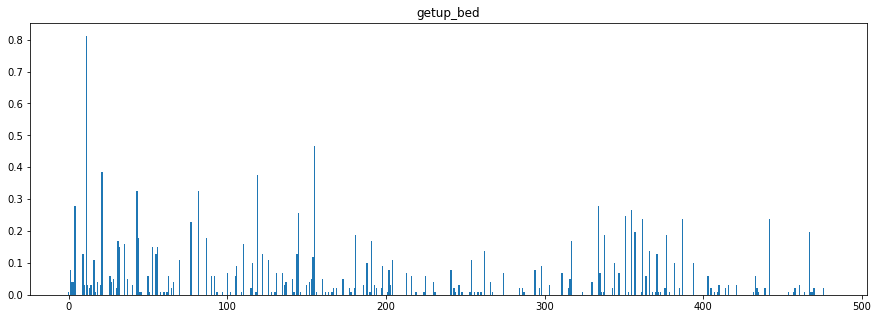

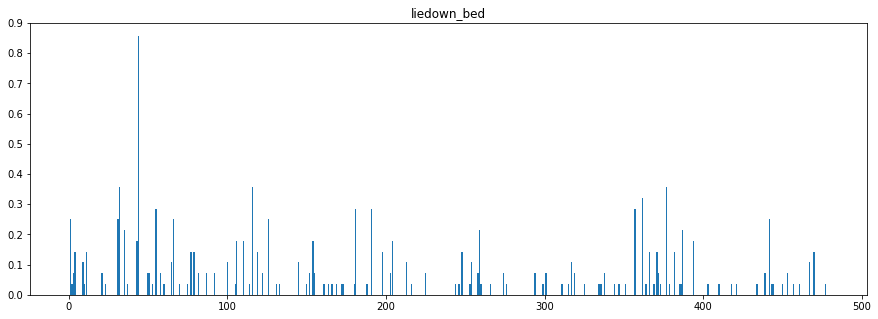

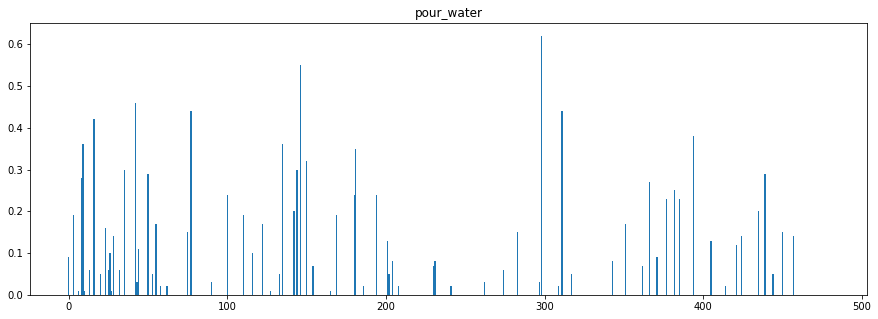

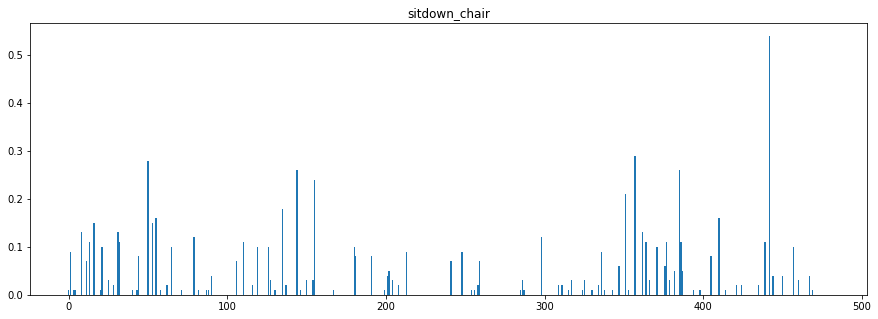

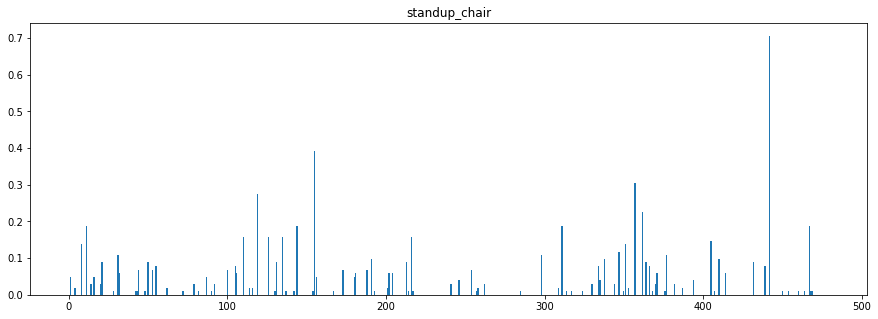

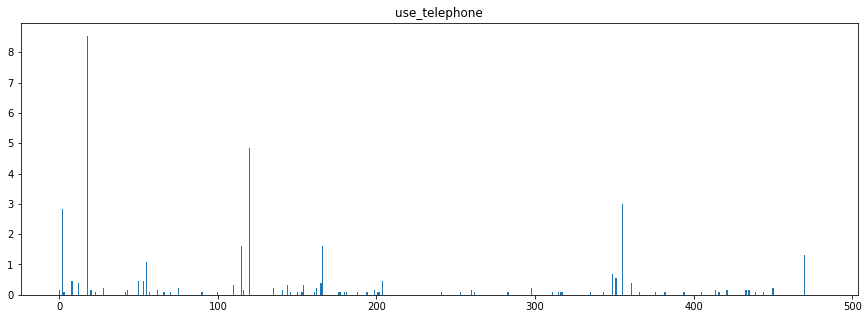

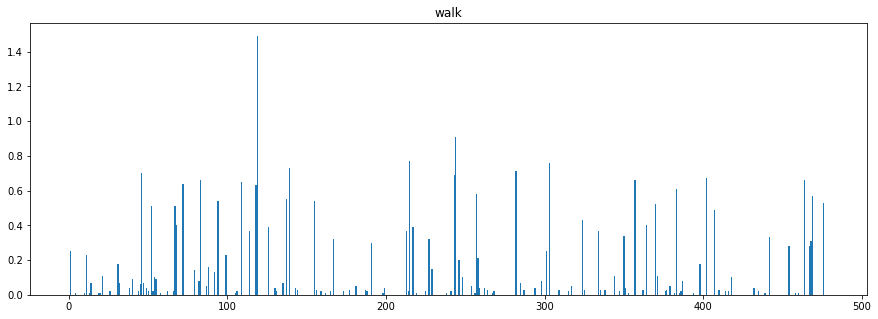

In [125]:
#get the feature vectors for each activity and plot the histogram
fvs = {}
for act in activities:
    l = activities_index_map[act]
    fvs[l] = []
    for example in examples[l]:
        example_data = example[:len(example)//sample_length * sample_length].reshape((len(example)//sample_length, sample_length*3))
        c = kmeans.predict(example_data)
        fv = [0 for _ in range(num_clusters)]
        for i in c:
            fv[i] += 1
        fvs[l] += [fv]
for act in activities:
    l = activities_index_map[act]
    mean = np.mean(np.array(fvs[l]), axis=0)
    plt.figure(figsize=(15,5))
    plt.bar(range(num_clusters), mean)
    plt.title(act)
        

In [157]:
#Build the classifer using random forest
data = [] #
for act in activities:
    l = activities_index_map[act]
    for i in fvs[l]:
        data += [i + [l]]
data = np.array(data)
rfc = RandomForestClassifier(criterion="gini", max_depth = 50, n_estimators = 1000)
print(len(data))

839


In [158]:
#(i) the average error rate over 3 fold cross validation
#(ii) the class confusion matrix of your classifier for the fold with the lowest error, i.e. just one matrix for the 3 folds.
folds = [None for _ in range(3)]
np.random.shuffle(data)
folds[0] = data[:280]
folds[1] = data[280:560]
folds[2] = data[560:]
accs = []
CM = np.zeros((14,14))
for i in range(3):
    train = np.concatenate((folds[(i+1)%3], folds[(i+2)%3]), axis=0)
    test = folds[i]
    rfc.fit(train[:,:-1], train[:,-1])
    predictions = rfc.predict(test[:,:-1])
    accs.append(np.sum(np.where(predictions == test[:,-1], 1, 0)) / len(predictions))
    for i in range(len(predictions)):
        CM[test[:,-1][i]][predictions[i]] += 1
print(sum(accs)/3)
print(CM)
    
    

0.7413765147636115
[[ 8.  0.  0.  0.  0.  0.  0.  1.  0.  2.  0.  1.  0.  0.]
 [ 0. 87.  0.  0.  0.  0.  0.  2.  0.  1.  4.  3.  0.  5.]
 [ 0.  0. 22.  0.  6.  0.  0.  0.  0.  1.  1.  1.  0.  0.]
 [ 0. 12.  0. 29.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0. 96.  0.  0.  0.  0.  3.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  1.  1.  0.  0.  0.  3.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  3.  0.  0.  0.  0.]
 [ 0.  3.  1.  0.  4.  0.  0. 58.  0.  5.  4. 26.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0. 10.  0.  3. 12.  2.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0. 98.  2.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  4.  0.  2. 79. 15.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  4.  0.  1. 23. 73.  0.  0.]
 [ 0.  0.  0.  0.  4.  0.  0.  0.  0.  4.  3.  0.  2.  0.]
 [ 0. 21.  0.  0.  0.  0.  0.  1.  0.  0.  4.  5.  0. 69.]]
